# Chargement Librairies et Fichier

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer


In [10]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')


In [25]:
class DropNARows(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.dropna(how='any')
    
# Transformer pour supprimer les colonnes spécifiées
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns)
    

# Transformer pour remplacer 'Alone' par 'Single' dans la colonne 'Marital_Status'
class ReplaceMaritalStatus(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()  # Créer une copie pour éviter la modification de la DataFrame d'origine
        X_copy.loc[:, 'Marital_Status'] = X_copy['Marital_Status'].replace('Alone', 'Single')
        return X_copy

# Transformer pour supprimer les lignes où 'Marital_Status' est 'Absurd' ou 'YOLO'
class FilterMaritalStatus(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[~X['Marital_Status'].isin(['Absurd', 'YOLO'])]

# Transformer pour supprimer les lignes où 'Year_Birth' est inférieur à 1930
class FilterYearBirth(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[X['Year_Birth'] >= 1930]
    
class AddEducationNumColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        mapping = {'Basic': 1, '2n Cycle': 2, 'Graduation': 3, 'Master': 4, 'PhD': 5}
        X['Education_Num'] = X['Education'].replace(mapping)
        return X
    
class ConvertDateToDays(BaseEstimator, TransformerMixin):
    def __init__(self, date_reference):
        self.date_reference = date_reference
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Dt_Customer'] = pd.to_datetime(X['Dt_Customer'], format='%d-%m-%Y')
        X['Days_From_Reference'] = (X['Dt_Customer'] - self.date_reference).dt.days
        return X.drop(columns=['Dt_Customer'])  # Supprimer la colonne originale de la date

colonnes_a_supprimer = ['ID', 'Z_CostContact', 'Z_Revenue', 'Complain']
date_reference = pd.to_datetime('2017-01-01')  
colonnes_numeriques = ['Year_Birth', 'Education_Num','Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds']
# 'NumStorePurchases', 'NumWebVisitsMonth','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Response','Days_From_Reference', 'NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases'

# Pipeline de preprocessing

In [26]:
preprocessor = ColumnTransformer([
    ('onehot_marital', OneHotEncoder(), ['Marital_Status']), 
    ('scaler', PowerTransformer(), colonnes_numeriques ),  # Encodage one-hot de la colonne 'Marital_Status'
    ('drop', 'passthrough', colonnes_a_supprimer),  # Suppression des colonnes spécifiées
],)  # 'passthrough' garde toutes les colonnes non spécifiées

# Création du pipeline de prétraitement
pipeline = Pipeline([
    ('drop_na_rows', DropNARows()),  # Suppression des lignes avec des valeurs manquantes
    ('replace_marital_status', ReplaceMaritalStatus()),  # Remplacement de 'Alone' par 'Single' dans 'Marital_Status'
    ('filter_marital_status', FilterMaritalStatus()),  # Suppression des lignes où 'Marital_Status' est 'Absurd' ou 'YOLO'
    ('filter_year_birth', FilterYearBirth()),  # Suppression des lignes où 'Year_Birth' est inférieur à 1930
    ('convert_date_to_days', ConvertDateToDays(date_reference)),  # Conversion de la date en nombre de jours
    ('add_education_num', AddEducationNumColumn()),  # Ajout de la colonne 'Education_Num'
    ('drop_education', DropColumns(columns=['Education'])),
    ('preprocess', preprocessor)  # Prétraitement final avec le ColumnTransformer
])

# Application du pipeline de prétraitement
df_preprocessed = pipeline.fit_transform(df)

In [27]:
pipeline


Pipeline(steps=[('drop_na_rows', DropNARows()),
                ('replace_marital_status', ReplaceMaritalStatus()),
                ('filter_marital_status', FilterMaritalStatus()),
                ('filter_year_birth', FilterYearBirth()),
                ('convert_date_to_days',
                 ConvertDateToDays(date_reference=Timestamp('2017-01-01 00:00:00'))),
                ('add_education_num', AddEducationNumColumn()),
                ('drop_education', DropColumns...
                 ColumnTransformer(transformers=[('onehot_marital',
                                                  OneHotEncoder(),
                                                  ['Marital_Status']),
                                                 ('scaler', PowerTransformer(),
                                                  ['Year_Birth',
                                                   'Education_Num', 'Income',
                                                   'Kidhome', 'Teenhome',
                                                   'Recency', 'MntWines',
                                                   'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds']),
                                                 ('drop', 'passthrough',
                                                  ['ID', 'Z_CostContact',
                                                   'Z_Revenue',
                                                   'Complain'])]))])

# Modélisation

## K-Means

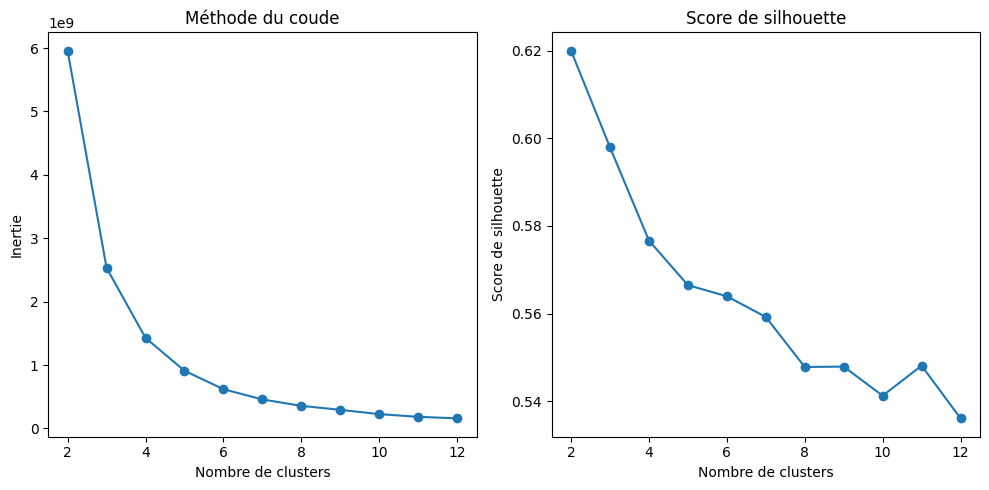

In [28]:
# Liste pour stocker les valeurs d'inertie et de score de silhouette
inertie = []
silhouette_scores = []

# Définir la plage de nombres de clusters à tester
nombre_clusters = range(2, 13)

# Calculer l'inertie et le score de silhouette pour chaque nombre de clusters
for k in nombre_clusters:
    # Créer le pipeline avec le nombre de clusters actuel
    pipeline = Pipeline([
        ('drop_na_rows', DropNARows()),
        ('replace_marital_status', ReplaceMaritalStatus()),
        ('filter_marital_status', FilterMaritalStatus()),
        ('filter_year_birth', FilterYearBirth()),
        ('add_education_num', AddEducationNumColumn()),
        ('drop_education', DropColumns(columns=['Education'])),
        ('convert_date_to_days', ConvertDateToDays(date_reference)),  # Conversion de la date en nombre de jours
        ('preprocess', preprocessor),
        ('kmeans', KMeans(n_clusters=k))  # KMeans avec le nombre de clusters actuel
    ])
    
    # Appliquer le pipeline à vos données
    pipeline.fit(df)
    
    # Calculer l'inertie et l'ajouter à la liste
    inertie.append(pipeline.named_steps['kmeans'].inertia_)
    
    # Obtenir les labels de clustering
    labels = pipeline.predict(df)
    
    # Calculer le score de silhouette et l'ajouter à la liste
    silhouette_scores.append(silhouette_score(df_preprocessed, labels))

# Tracer la courbe d'inertie
plt.figure(figsize=(10, 5))

# Plot de l'inertie
plt.subplot(1, 2, 1)
plt.plot(nombre_clusters, inertie, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')

# Plot du score de silhouette
plt.subplot(1, 2, 2)
plt.plot(nombre_clusters, silhouette_scores, marker='o')
plt.title('Score de silhouette')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')

plt.tight_layout()
plt.show()


Le meilleur compromis est ici pour k=5

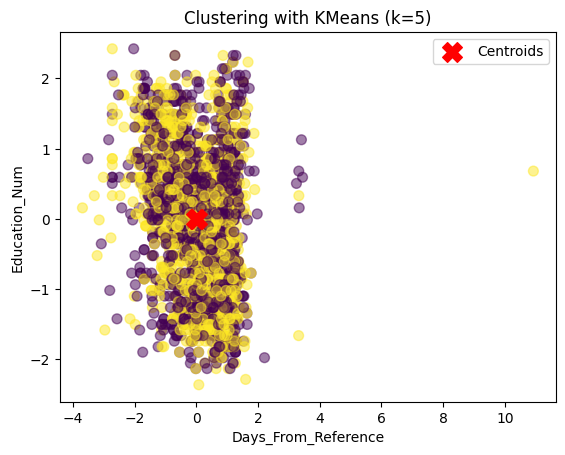

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# Assurez-vous que df est votre DataFrame original

# Créer un pipeline de prétraitement uniquement
preprocessing_pipeline = Pipeline([
    ('drop_na_rows', DropNARows()),
    ('replace_marital_status', ReplaceMaritalStatus()),
    ('filter_marital_status', FilterMaritalStatus()),
    ('filter_year_birth', FilterYearBirth()),
    ('add_education_num', AddEducationNumColumn()),
    ('drop_education', DropColumns(columns=['Education'])),
    ('convert_date_to_days', ConvertDateToDays(date_reference)),  # Conversion de la date en nombre de jours
    ('preprocess', preprocessor)
])

# Appliquer le prétraitement pour obtenir le DataFrame filtré
df_filtered = preprocessing_pipeline.fit_transform(df)

# Créer le pipeline avec KMeans
pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=2))  # KMeans avec k=5
])

# Entraîner le modèle
pipeline.fit(df_filtered)

# Obtenir les labels des clusters
labels = pipeline.named_steps['kmeans'].labels_

# Convertir df_filtered en DataFrame pour ajouter les labels de cluster
df_filtered = pd.DataFrame(df_filtered, columns=preprocessing_pipeline.named_steps['preprocess'].get_feature_names_out())
df_filtered['Cluster'] = labels


# Visualisation des clusters
feature1 = 'scaler__Income'
feature2 = 'scaler__Year_Birth'

plt.scatter(df_filtered[feature1], df_filtered[feature2], c=df_filtered['Cluster'], cmap='viridis', s=50, alpha=0.5)
plt.scatter(pipeline.named_steps['kmeans'].cluster_centers_[:, df_filtered.columns.get_loc(feature1)], 
            pipeline.named_steps['kmeans'].cluster_centers_[:, df_filtered.columns.get_loc(feature2)], 
            s=200, c='red', marker='X', label='Centroids')
plt.xlabel('Days_From_Reference')
plt.ylabel('Education_Num')
plt.title('Clustering with KMeans (k=5)')
plt.legend()
plt.show()


In [ ]:
from sklearn.decomposition import PCA

# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_preprocessed)  # df_preprocessed contient vos données après prétraitement

# Tracer les clusters
plt.figure(figsize=(8, 6))
for cluster_label in set(cluster_labels):  # Boucle sur les différents clusters
    plt.scatter(X_pca[cluster_labels == cluster_label, 0], 
                X_pca[cluster_labels == cluster_label, 1], 
                label=f'Cluster {cluster_label}', alpha=0.7)

plt.title('Clusters dans l\'espace de faible dimension (PCA)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend()
plt.grid(True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


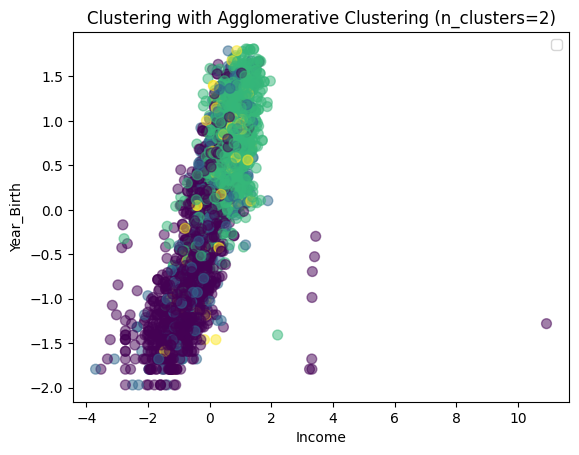

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Assurez-vous que df est votre DataFrame original
# Suppose that df is already defined

# Placeholder for custom transformers: DropNARows, ReplaceMaritalStatus, FilterMaritalStatus, FilterYearBirth,
# AddEducationNumColumn, DropColumns, ConvertDateToDays, preprocessor

# Create a preprocessing pipeline (adjust accordingly to your preprocessing steps)
preprocessing_pipeline = Pipeline([
    ('drop_na_rows', DropNARows()),
    ('replace_marital_status', ReplaceMaritalStatus()),
    ('filter_marital_status', FilterMaritalStatus()),
    ('filter_year_birth', FilterYearBirth()),
    ('add_education_num', AddEducationNumColumn()),
    ('drop_education', DropColumns(columns=['Education'])),
    ('convert_date_to_days', ConvertDateToDays(date_reference)),  # Conversion de la date en nombre de jours
    ('preprocess', preprocessor)
])

# Apply the preprocessing pipeline to get the filtered DataFrame
df_filtered = preprocessing_pipeline.fit_transform(df)

# Convert df_filtered to a DataFrame for better handling
df_filtered = pd.DataFrame(df_filtered, columns=preprocessing_pipeline.named_steps['preprocess'].get_feature_names_out())

# Create the clustering pipeline with AgglomerativeClustering
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optionally scale the data
    ('agglomerative_clustering', AgglomerativeClustering(n_clusters=4))
])

# Fit the model
pipeline.fit(df_filtered)

# Get the cluster labels
labels = pipeline.named_steps['agglomerative_clustering'].labels_

# Add cluster labels to the DataFrame
df_filtered['Cluster'] = labels

# Visualize the clusters
feature1 = 'scaler__Income'  # Adjust feature names according to your transformed DataFrame
feature2 = 'scaler__MntWines'  # Adjust feature names according to your transformed DataFrame

plt.scatter(df_filtered[feature1], df_filtered[feature2], c=df_filtered['Cluster'], cmap='viridis', s=50, alpha=0.5)
plt.xlabel('Income')
plt.ylabel('Year_Birth')
plt.title('Clustering with Agglomerative Clustering (n_clusters=2)')
plt.legend()
plt.show()
